# 01: Protein Embeddings with ProToPhen

This notebook demonstrates how to extract and combine protein embeddings using ProToPhen.
We'll cover:

1. **Loading proteins** - Working with `Protein` and `ProteinLibrary` classes
2. **ESM-2 embeddings** - Extracting learned representations from protein language models
3. **Physicochemical features** - Computing interpretable biochemical descriptors
4. **Embedding fusion** - Combining multiple embedding types
5. **Visualisation** - Exploring the embedding space

**Contents**
1. [Setup and Imports](#1-setup-and-imports)
2. [Working with Proteins](#2-working-with-proteins)
3. [ESM-2 Embeddings](#3-esm-2-embeddings)
4. [Physicochemical Features](#4-physicochemical-features)
5. [Embedding Fusion](#5-embedding-fusion)
6. [Saving and Loading Embeddings](#6-saving-and-loading-embeddings)
7. [Visualising the Embedding Space](#7-visualising-the-embedding-space)
8. [Summary & Next Steps](#8-summary-and-next-steps)

## Background

Protein embeddings are numerical representations that capture the biological properties
of amino acid sequences. ProToPhen currently uses two complementary approaches:

- **ESM-2**: A protein language model trained on millions of sequences that learns
  evolutionary and structural patterns (high-dimensional, ~1280 features)
- **Physicochemical features**: Interpretable biochemical properties like hydrophobicity,
  charge, and secondary structure propensities (~430 features)

These embeddings form the input to our protein-to-phenotype prediction models.

## 1. Setup and Imports

In [1]:
# Core imports
import numpy as np
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ProToPhen imports
from protophen.data.protein import Protein, ProteinLibrary, validate_sequence
from protophen.embeddings.esm import ESMEmbedder, list_esm_models
from protophen.embeddings.physicochemical import (
    PhysicochemicalCalculator,
    PhysicochemicalConfig,
    calculate_all_features,
)
from protophen.embeddings.fusion import EmbeddingFusion, FusionMethod
from protophen.analysis.visualisation import (
    plot_embedding_space,
    plot_pca,
    plot_heatmap,
    plot_correlation_matrix,
    save_figure,
    PlotConfig,
)

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Check GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Output directories
OUTPUT_DIR = Path("outputs/01_protein_embeddings")
FIGURES_DIR = OUTPUT_DIR / "figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PyTorch version: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA RTX 2000 Ada Generation Laptop GPU


## 2. Working with Proteins

ProToPhen provides the following classes for working with proteins:
- `Protein` for representing individual proteins, and
- `ProteinLibrary` for managing collections of proteins. 

Let's start by creating some proteins.

### 2.1 Creating Protein Objects

In [2]:
# Create a protein from a sequence
protein1 = Protein(
    sequence="MKFLILLFNILCLFPVLAADNHGVGPQGASGVDPITFDINSNQTGVQLTLF",
    name="example_protein_1",
    source="de_novo",
    metadata={
        "design_method": "RFdiffusion",
        "target": "cell_surface_receptor",
        "batch": "design_v1",
    }
)

print(f"Protein: {protein1}")
print(f"Length: {protein1.length} residues")
print(f"Molecular weight: {protein1.molecular_weight:.1f} Da")
print(f"Sequence hash: {protein1.hash}")

Protein: sequence='MKFLILLFNILCLFPVLAADNHGVGPQGASGVDPITFDINSNQTGVQLTLF' name='example_protein_1' source='de_novo' metadata={'design_method': 'RFdiffusion', 'target': 'cell_surface_receptor', 'batch': 'design_v1'} embeddings={} structure=None
Length: 51 residues
Molecular weight: 5461.8 Da
Sequence hash: 18df45c51444a357


In [3]:
# Explore computed properties
print("Amino acid composition:")
aa_comp = protein1.amino_acid_composition
for aa, freq in sorted(aa_comp.items(), key=lambda x: -x[1])[:10]:
    print(f"  {aa}: {freq:.3f}")

Amino acid composition:
  L: 0.157
  G: 0.098
  F: 0.098
  I: 0.078
  V: 0.078
  N: 0.078
  D: 0.059
  T: 0.059
  Q: 0.059
  A: 0.059


### 2.2 Creating a Protein Library

For batch processing, we use the `ProteinLibrary` class to manage collections of proteins.

In [4]:
# Create a library with example de novo designed proteins
example_sequences = [
    ("design_001", "MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQDNLSGAEKAVQVKVKALPDAQFEVVHSLAKWKRQQIAAALEHHHHHH"),
    ("design_002", "GAMGSEIEHIEEAIANAKTKADHIAVTDASNAVLNKAKNAKGVDVAKNAVKQLKADAKQAGHHHHHH"),
    ("design_003", "MKMEELFKKHKIVAVLRANSVEEAKKKALAVFLGGVHLIEITFTVPDADTVIKELSFLKEMGAIIGAGTVTSVEQARKAVESGAEFIVSPHLDEEISQFCKEKGVFYMPGVMTPTELVKAMKLGHTILKLFPGEVVGPQFVKAMKGPFPNVKFVPTGGVNLDNVCEWFKAGVLAVGVGSALVKGTPVEVAEKAKAFVEKIRGCTE"),
    ("design_004", "MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITLGMDELYK"),
    ("design_005", "MVSKGEEDNMASLPATHELHIFGSINGVDFDMVGQGTGNPNDGYEELNLKSTKGDLQFSPWILVPHIGYGFHQYLPYPDGMSPFQAAMVDGSGYQVHRTMQFEDGASLTVNYRYTYEGSHIKGEAQVKGTGFPADGPVMTNSLTAADWCRSKKTYPNDKTIISTFKWSYTTGNGKRYRSTARTTYTFAKPMAANYLKNQPMYVFRKTELKHSKTELN"),
]

# Create library
library = ProteinLibrary(name="de_novo_designs_v1")

for name, seq in example_sequences:
    protein = Protein(
        sequence=seq,
        name=name,
        source="de_novo",
        metadata={"batch": "tutorial_examples"}
    )
    library.add(protein)

print(f"Library: {library}")
print(f"\nLibrary summary:")
summary = library.summary()
for key, value in summary.items():
    print(f"  {key}: {value}")

Library: ProteinLibrary(name='de_novo_designs_v1', count=5)

Library summary:
  name: de_novo_designs_v1
  count: 5
  length_stats: {'min': 67, 'max': 238, 'mean': np.float64(163.8), 'median': np.float64(205.0)}
  sources: {'de_novo': 5}
  embedding_coverage: {}


In [5]:
# Explore individual proteins
print("\nProteins in library:")
for protein in library:
    print(f"  {protein.name}: {protein.length} residues, MW={protein.molecular_weight:.0f} Da")


Proteins in library:
  design_001: 92 residues, MW=10425 Da
  design_002: 67 residues, MW=7049 Da
  design_003: 205 residues, MW=22089 Da
  design_004: 238 residues, MW=26843 Da
  design_005: 217 residues, MW=24302 Da


### 2.3 Loading from FASTA Files

You can also load proteins from FASTA files:

Note: Make sure to specify a source (e.g. "de novo") when constructing the library.

In [6]:
# Example: Loading from FASTA (uncomment to use with your own file)
# library.add_from_fasta("path/to/proteins.fasta", source="de_novo")

# Save current library to JSON for later use
output_dir = Path("outputs/01_protein_embeddings/embeddings")
output_dir.mkdir(parents=True, exist_ok=True)

library.to_json(output_dir / "example_library.json", include_embeddings=False)
print(f"Saved library to {output_dir / 'example_library.json'}")

Saved library to outputs\01_protein_embeddings\embeddings\example_library.json


## 3. ESM-2 Embeddings

ESM-2 (Evolutionary Scale Modeling) is a protein language model trained on millions
of protein sequences. It captures evolutionary and structural information in 
high-dimensional embeddings.

### Available Models

| Model | Parameters | Embedding Dim | GPU Memory | Use Case |
|-------|-----------|---------------|------------|----------|
| esm2_t6_8M | 8M | 320 | ~500MB | Quick prototyping |
| esm2_t12_35M | 35M | 480 | ~1GB | Light usage |
| esm2_t30_150M | 150M | 640 | ~2GB | Balanced |
| esm2_t33_650M | 650M | 1280 | ~4GB | Good accuracy |
| esm2_t36_3B | 3B | 2560 | ~12GB | Best accuracy |

In [7]:
# List available models
print("Available ESM-2 models:")
for model_name, info in list_esm_models().items():
    print(f"  {model_name}: {info['layers']} layers, {info['dim']} dim")

Available ESM-2 models:
  esm2_t6_8M_UR50D: 6 layers, 320 dim
  esm2_t12_35M_UR50D: 12 layers, 480 dim
  esm2_t30_150M_UR50D: 30 layers, 640 dim
  esm2_t33_650M_UR50D: 33 layers, 1280 dim
  esm2_t36_3B_UR50D: 36 layers, 2560 dim


### 3.1 Initialise the Embedder

In [8]:
# Initialise ESM-2 embedder
# Use a smaller model for the tutorial (faster); switch to esm2_t33_650M_UR50D or esm2_t36_3B_UR50D for production
embedder = ESMEmbedder(
    model_name="esm2_t6_8M_UR50D",  # Smallest model for demo; use "esm2_t36_3B_UR50D" for best results
    pooling="mean",  # Pool token embeddings to sequence embedding
    batch_size=4,    # Adjust based on GPU memory
    use_fp16=True,   # Half precision for faster inference
    # cache_dir="../cache/esm_embeddings",  # Uncomment to enable caching
)

print(f"Embedder: {embedder}")
print(f"Output dimension: {embedder.output_dim}")

2026-02-15 23:26:14 | INFO     | protophen.embeddings.esm:__init__:166 | Initialised ESMEmbedder: model=esm2_t6_8M_UR50D, dim=320, device=cuda


Embedder: ESMEmbedder(model=esm2_t6_8M_UR50D, dim=320, pooling=mean, device=cuda)
Output dimension: 320


### 3.2 Pooling Strategies

ESM-2 outputs embeddings for each token (amino acid). We pool these to get a single
sequence embedding:

- **mean**: Average over all residue embeddings (recommended)
- **cls**: Use the [CLS] (Classify) token embedding
- **max**: Max pooling over residues
- **mean_cls**: Concatenate mean and CLS embeddings

### 3.3 Embed a Single Protein

In [9]:
# Embed a single sequence
single_embedding = embedder.embed_sequence(protein1.sequence)
print(f"Single protein embedding shape: {single_embedding.shape}")
print(f"Embedding statistics:")
print(f"  Mean: {single_embedding.mean():.4f}")
print(f"  Std:  {single_embedding.std():.4f}")
print(f"  Min:  {single_embedding.min():.4f}")
print(f"  Max:  {single_embedding.max():.4f}")

2026-02-15 23:26:14 | INFO     | protophen.embeddings.esm:_load_model:186 | Loading ESM-2 model: esm2_t6_8M_UR50D
2026-02-15 23:26:15 | INFO     | protophen.embeddings.esm:_load_model:211 | Model loaded successfully on cuda


Single protein embedding shape: (320,)
Embedding statistics:
  Mean: -0.0096
  Std:  0.3102
  Min:  -4.9515
  Max:  0.3722


### 3.4 Embed a Protein Library

In [10]:
# Embed all proteins in the library
esm_embeddings = embedder.embed_library(
    library,
    embedding_key="esm2",
    show_progress=True,
)

print(f"\nEmbedding matrix shape: {esm_embeddings.shape}")
print(f"(n_proteins, embedding_dim)")

# Verify embeddings are stored in proteins
for protein in library[:3]:
    print(f"  {protein.name}: has ESM-2 embedding = {protein.has_embeddings}")
    print(f"    Embedding types: {protein.embedding_types}")

2026-02-15 23:26:15 | INFO     | protophen.embeddings.esm:embed_library:511 | Embedding 5 proteins from library 'de_novo_designs_v1'
2026-02-15 23:26:15 | INFO     | protophen.embeddings.esm:embed_sequences:416 | Computing embeddings for 5 sequences (0 cached)


Embedding:   0%|          | 0/2 [00:00<?, ?it/s]


Embedding matrix shape: (5, 320)
(n_proteins, embedding_dim)
  design_001: has ESM-2 embedding = True
    Embedding types: ['esm2']
  design_002: has ESM-2 embedding = True
    Embedding types: ['esm2']
  design_003: has ESM-2 embedding = True
    Embedding types: ['esm2']


## 4. Physicochemical Features

Physicochemical features provide interpretable, biochemically meaningful descriptors.
These complement ESM-2's learned representations with explicit information about the protein's physicochemical constraints.

### Feature Groups

| Group | Features | Description |
|-------|----------|-------------|
| Amino acid composition | 20 | Frequency of each amino acid |
| Dipeptide composition | 400 | Frequency of each amino acid pair |
| Global properties | 5 | MW, length, instability, aliphatic index, aromaticity |
| Hydrophobicity | 2 | GRAVY score, hydrophobic moment |
| Secondary structure | 3 | Helix, sheet, turn propensities |
| Charge features | 4 | pI, charge at pH 7, positive/negative fractions |
| Sequence complexity | 2 | Shannon entropy, complexity score |

### 4.1 Initialise the Calculator

In [11]:
# Create calculator with default settings
calc = PhysicochemicalCalculator()

print(f"Calculator: {calc}")
print(f"Number of features: {calc.n_features}")
print(f"\nFeature groups:")
print(f"  - Amino acid composition: 20 features")
print(f"  - Dipeptide composition: 400 features")
print(f"  - Global properties: 5 features")
print(f"  - Hydrophobicity: 2 features")
print(f"  - Secondary structure: 3 features")
print(f"  - Charge features: 4 features")
print(f"  - Sequence complexity: 2 features")

2026-02-15 23:26:15 | INFO     | protophen.embeddings.physicochemical:__init__:561 | Initialised PhysicochemicalCalculator


Calculator: PhysicochemicalCalculator(n_features=436)
Number of features: 436

Feature groups:
  - Amino acid composition: 20 features
  - Dipeptide composition: 400 features
  - Global properties: 5 features
  - Hydrophobicity: 2 features
  - Secondary structure: 3 features
  - Charge features: 4 features
  - Sequence complexity: 2 features


### 4.2 Calculate Features for a Single Protein

In [12]:
# Calculate all features with descriptions
features_dict = calculate_all_features(protein1.sequence)

print(f"Sample features for {protein1.name}:")
print("-" * 50)

# Show a selection of interpretable features
interesting_features = [
    'molecular_weight', 'length', 'gravy', 'isoelectric_point',
    'charge_at_ph7', 'helix_fraction', 'sheet_fraction', 
    'instability_index', 'aromaticity', 'sequence_entropy'
]

for feat in interesting_features:
    if feat in features_dict:
        print(f"  {feat}: {features_dict[feat]:.4f}")

2026-02-15 23:26:15 | INFO     | protophen.embeddings.physicochemical:__init__:561 | Initialised PhysicochemicalCalculator


Sample features for example_protein_1:
--------------------------------------------------
  molecular_weight: 5461.3301
  length: 51.0000
  gravy: 0.7137
  isoelectric_point: 4.1597
  charge_at_ph7: -1.9539
  helix_fraction: 0.3234
  sheet_fraction: 0.3602
  instability_index: 32.8000
  aromaticity: 0.0980
  sequence_entropy: 3.7706


In [13]:
# Get feature descriptions
descriptions = calc.get_feature_descriptions()

print("\nFeature descriptions (sample):")
for feat in interesting_features[:5]:
    print(f"  {feat}: {descriptions.get(feat, 'N/A')}")


Feature descriptions (sample):
  molecular_weight: Molecular weight in Daltons
  length: Sequence length
  gravy: Grand average of hydropathicity
  isoelectric_point: Isoelectric point (pI)
  charge_at_ph7: Net charge at pH 7.0


### 4.3 Calculate Features for the Library

In [14]:
# Calculate physicochemical features for all proteins
physchem_embeddings = calc.calculate_for_library(
    library,
    embedding_key="physicochemical",
    show_progress=True,
)

print(f"Physicochemical matrix shape: {physchem_embeddings.shape}")

# Verify both embedding types are stored
for protein in library[:2]:
    print(f"\n{protein.name}:")
    print(f"  Embedding types: {protein.embedding_types}")
    for emb_type in protein.embedding_types:
        emb = protein.get_embedding(emb_type)
        print(f"    {emb_type}: shape={emb.shape}")

2026-02-15 23:26:15 | INFO     | protophen.embeddings.physicochemical:calculate_for_library:758 | Calculating features for 5 proteins


Calculating features:   0%|          | 0/5 [00:00<?, ?it/s]

Physicochemical matrix shape: (5, 436)

design_001:
  Embedding types: ['esm2', 'physicochemical']
    esm2: shape=(320,)
    physicochemical: shape=(436,)

design_002:
  Embedding types: ['esm2', 'physicochemical']
    esm2: shape=(320,)
    physicochemical: shape=(436,)


### 4.4 Customising Feature Calculation

You can exclude specific feature groups to reduce dimensionality:

In [15]:
# Create a lightweight calculator (without dipeptides)
config_light = PhysicochemicalConfig(
    include_aa_composition=True,
    include_dipeptide_composition=False,  # Skip 400 dipeptide features
    include_global_properties=True,
    include_hydrophobicity=True,
    include_secondary_structure=True,
    include_charge_features=True,
    include_sequence_complexity=True,
)

calc_light = PhysicochemicalCalculator(config_light)
print(f"Lightweight calculator: {calc_light.n_features} features (vs {calc.n_features} full)")

2026-02-15 23:26:15 | INFO     | protophen.embeddings.physicochemical:__init__:561 | Initialised PhysicochemicalCalculator


Lightweight calculator: 36 features (vs 436 full)


## 5. Embedding Fusion

Now we'll combine ESM-2 and physicochemical embeddings into unified representations.

### Fusion Methods

| Method | Description | Best For |
|--------|-------------|----------|
| **concatenate** | Simple concatenation | Default, preserves all information |
| **weighted** | Learned/fixed weights | When embedding importance varies |
| **attention** | Cross-attention fusion | Complex relationships |
| **gated** | Gated combination | Adaptive fusion |

### 5.1 Concatenation Fusion (Recommended)

In [16]:
# Create fusion module
fusion = EmbeddingFusion(
    method="concatenate",
    embedding_names=["esm2", "physicochemical"],
    normalise_inputs=True,   # L2-normalise before concatenating
    normalise_output=False,
)

print(f"Fusion: {fusion}")

2026-02-15 23:26:15 | INFO     | protophen.embeddings.fusion:__init__:423 | Initialised EmbeddingFusion: method=concatenate


Fusion: EmbeddingFusion(method=concatenate, embeddings=['esm2', 'physicochemical'])


In [17]:
# Fuse embeddings for the library
fused_embeddings = fusion.fuse_library(
    library,
    embedding_key="fused",
    show_progress=True,
)

print(f"Fused embedding shape: {fused_embeddings.shape}")
print(f"  ESM-2 dim: {embedder.output_dim}")
print(f"  Physicochemical dim: {calc.n_features}")
print(f"  Fused dim: {fused_embeddings.shape[1]}")

Fusing embeddings:   0%|          | 0/5 [00:00<?, ?it/s]

Fused embedding shape: (5, 756)
  ESM-2 dim: 320
  Physicochemical dim: 436
  Fused dim: 756


### 5.2 Verify All Embeddings

In [18]:
# Check that all embedding types are stored
print("Final embedding summary:")
print("-" * 60)

for protein in library:
    print(f"\n{protein.name}:")
    for emb_type in protein.embedding_types:
        emb = protein.get_embedding(emb_type)
        print(f"  {emb_type:20s}: shape={str(emb.shape):12s} mean={emb.mean():.4f}")

Final embedding summary:
------------------------------------------------------------

design_001:
  esm2                : shape=(320,)       mean=-0.0101
  physicochemical     : shape=(436,)       mean=24.4651
  fused               : shape=(756,)       mean=0.0006

design_002:
  esm2                : shape=(320,)       mean=-0.0106
  physicochemical     : shape=(436,)       mean=16.6501
  fused               : shape=(756,)       mean=0.0006

design_003:
  esm2                : shape=(320,)       mean=-0.0140
  physicochemical     : shape=(436,)       mean=51.4696
  fused               : shape=(756,)       mean=0.0000

design_004:
  esm2                : shape=(320,)       mean=-0.0100
  physicochemical     : shape=(436,)       mean=62.3764
  fused               : shape=(756,)       mean=0.0006

design_005:
  esm2                : shape=(320,)       mean=-0.0098
  physicochemical     : shape=(436,)       mean=56.4590
  fused               : shape=(756,)       mean=0.0006


## 6. Saving and Loading Embeddings

Embeddings can be computationally expensive to generate. You can compute them once, and save them for reuse.

In [19]:
# Save library with embeddings
library.to_json(
    output_dir / "library_with_embeddings.json",
    include_embeddings=True,
)
print(f"Saved library with embeddings to {output_dir / 'library_with_embeddings.json'}")

# Save embedding matrices as NPY files (more efficient for large datasets)
np.save(output_dir / "esm2_embeddings.npy", library.get_embedding_matrix("esm2"))
np.save(output_dir / "physicochemical_embeddings.npy", library.get_embedding_matrix("physicochemical"))
np.save(output_dir / "fused_embeddings.npy", library.get_embedding_matrix("fused"))

# Save protein IDs for reference
with open(output_dir / "protein_ids.txt", "w") as f:
    for protein in library:
        f.write(f"{protein.name}\n")

print(f"Saved embedding matrices to {output_dir}")

Saved library with embeddings to outputs\01_protein_embeddings\embeddings\library_with_embeddings.json
Saved embedding matrices to outputs\01_protein_embeddings\embeddings


In [20]:
# Load library with embeddings (demonstration)
loaded_library = ProteinLibrary.from_json(output_dir / "library_with_embeddings.json")
print(f"Loaded library: {loaded_library}")

# Verify embeddings were loaded
for protein in loaded_library[:2]:
    print(f"  {protein.name}: {protein.embedding_types}")

Loaded library: ProteinLibrary(name='de_novo_designs_v1', count=5)
  design_001: ['esm2', 'physicochemical', 'fused']
  design_002: ['esm2', 'physicochemical', 'fused']


## 7. Visualising the Embedding Space

Let's explore the embedding space using dimensionality reduction.

### 7.1 PCA Visualisation

2026-02-15 23:26:16 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\01_protein_embeddings\figures\length_categories_pca.png


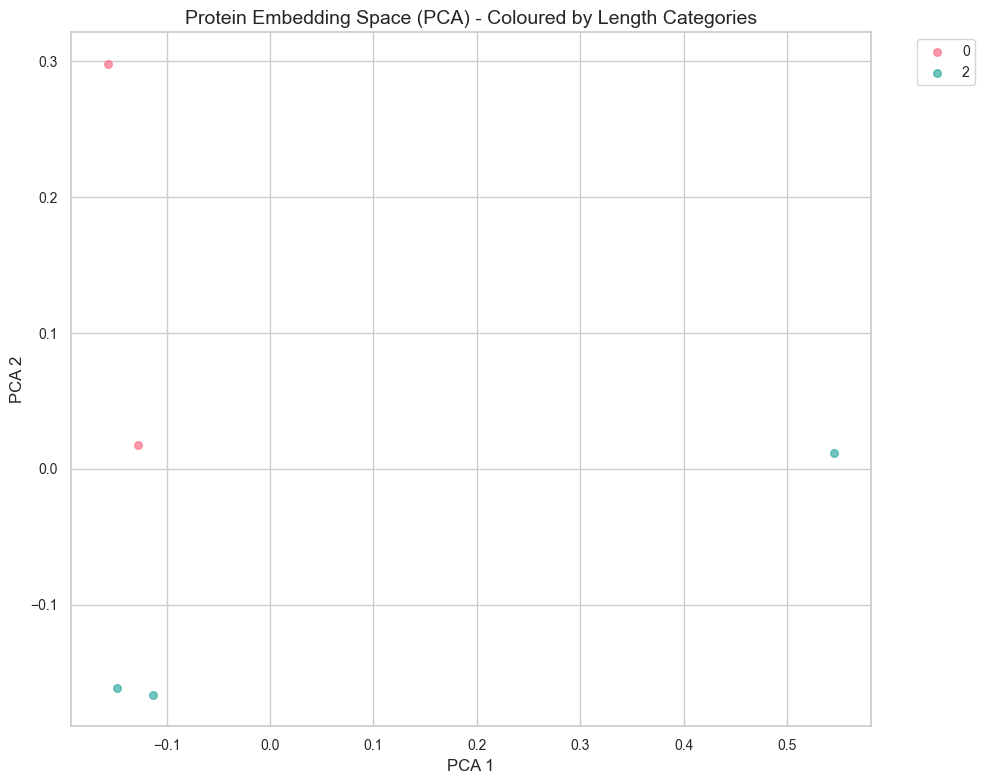

In [21]:
# Get fused embeddings matrix
embedding_matrix = library.get_embedding_matrix("fused")

# Create labels based on protein length categories
lengths = np.array([p.length for p in library])
length_categories = np.digitize(lengths, bins=[100, 200, 300])
category_names = {0: "Short (<100)", 1: "Medium (100-200)", 2: "Long (200-300)", 3: "Very Long (>300)"}
labels = np.array([category_names[c] for c in length_categories])

# Plot PCA
fig, ax = plot_pca(
    embedding_matrix,
    labels=length_categories,
    title="Protein Embedding Space (PCA) - Coloured by Length Categories",
)
save_figure(fig, FIGURES_DIR / "length_categories_pca.png")
plt.show()

### 7.2 Compare Different Embedding Types

2026-02-15 23:26:16 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\01_protein_embeddings\figures\embedding_comparison_pca.png


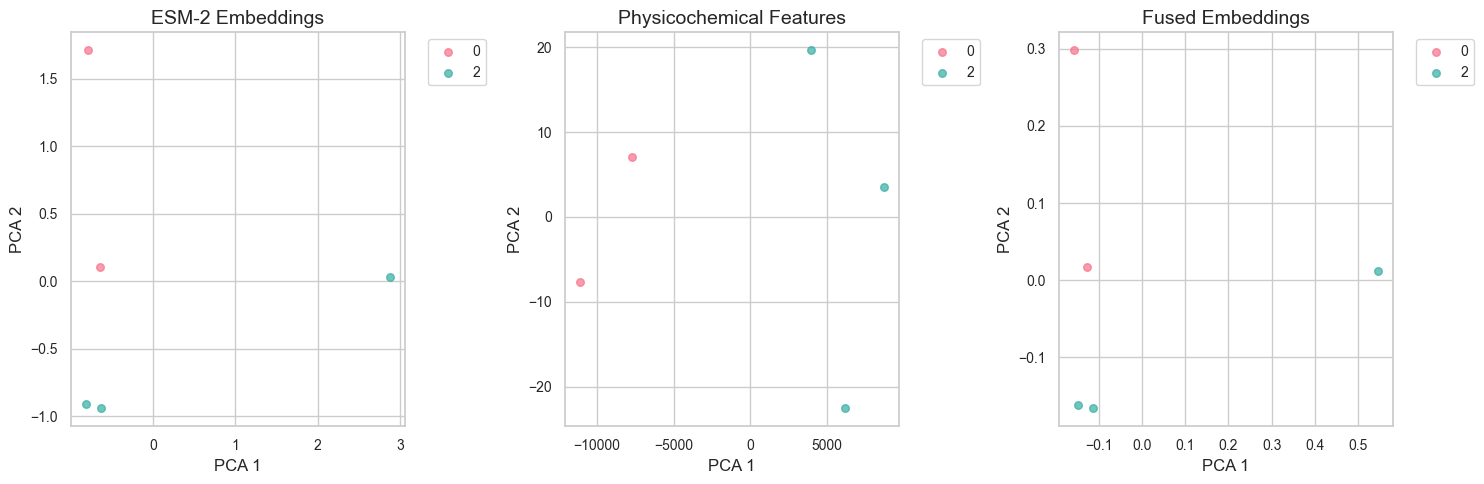

In [22]:
# Compare ESM-2 vs physicochemical vs fused embeddings
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

embedding_types = ["esm2", "physicochemical", "fused"]
titles = ["ESM-2 Embeddings", "Physicochemical Features", "Fused Embeddings"]

for ax, emb_type, title in zip(axes, embedding_types, titles):
    emb_matrix = library.get_embedding_matrix(emb_type)
    plot_pca(emb_matrix, labels=length_categories, title=title, ax=ax)

plt.tight_layout()
save_figure(fig, FIGURES_DIR / "embedding_comparison_pca.png")
plt.show()

### 7.3 Physicochemical Feature Correlations

2026-02-15 23:26:17 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\01_protein_embeddings\figures\physchem_feat_correl_matrix.png


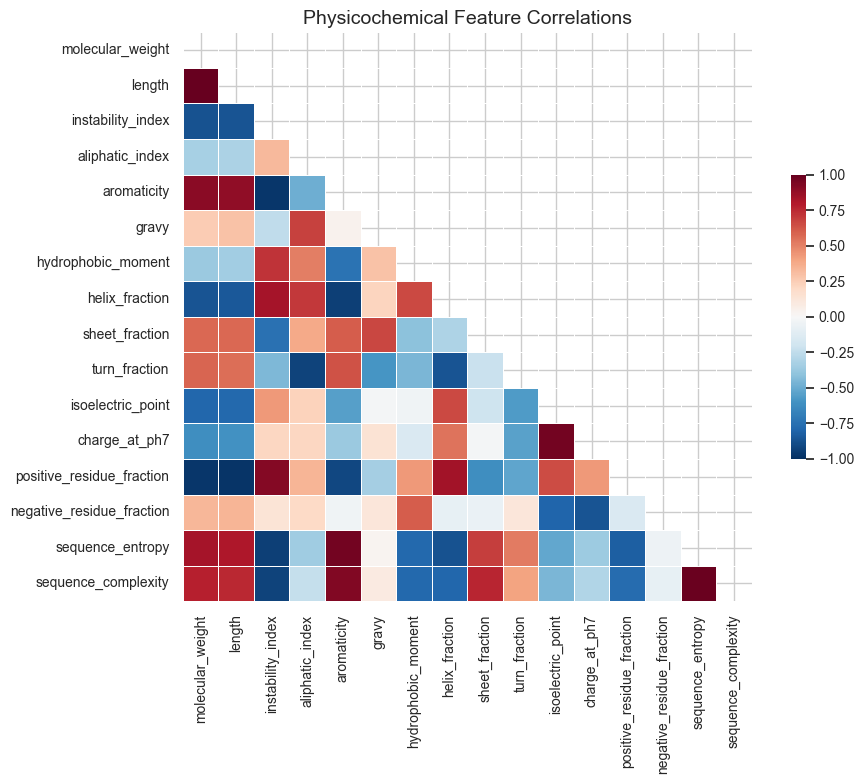

In [23]:
# Visualise correlations between physicochemical features
# Use a subset of interpretable features
physchem_matrix = library.get_embedding_matrix("physicochemical")

# Get feature names
feature_names = calc.feature_names

# Select interpretable features (skip dipeptides for visualisation)
interpretable_indices = [
    i for i, name in enumerate(feature_names) 
    if not name.startswith("dipep_") and not name.startswith("aa_comp_")
]
interpretable_names = [feature_names[i] for i in interpretable_indices]
interpretable_data = physchem_matrix[:, interpretable_indices]

# Plot correlation matrix
fig, ax = plot_correlation_matrix(
    interpretable_data,
    feature_names=interpretable_names,
    title="Physicochemical Feature Correlations",
    figsize=(10, 8),
)
save_figure(fig, FIGURES_DIR / "physchem_feat_correl_matrix.png")
plt.show()

### 7.4 Feature Statistics Across Library

In [24]:
# Create a summary DataFrame of key features
feature_data = []
for protein in library:
    features = calculate_all_features(protein.sequence)
    features['name'] = protein.name
    features['length'] = protein.length
    feature_data.append(features)

df = pd.DataFrame(feature_data)

# Display key statistics
key_columns = ['name', 'length', 'molecular_weight', 'gravy', 'isoelectric_point', 
               'charge_at_ph7', 'instability_index', 'aromaticity']
print("Protein Feature Summary:")
print(df[key_columns].to_string(index=False))

2026-02-15 23:26:17 | INFO     | protophen.embeddings.physicochemical:__init__:561 | Initialised PhysicochemicalCalculator
2026-02-15 23:26:17 | INFO     | protophen.embeddings.physicochemical:__init__:561 | Initialised PhysicochemicalCalculator
2026-02-15 23:26:17 | INFO     | protophen.embeddings.physicochemical:__init__:561 | Initialised PhysicochemicalCalculator
2026-02-15 23:26:17 | INFO     | protophen.embeddings.physicochemical:__init__:561 | Initialised PhysicochemicalCalculator
2026-02-15 23:26:17 | INFO     | protophen.embeddings.physicochemical:__init__:561 | Initialised PhysicochemicalCalculator


Protein Feature Summary:
      name  length  molecular_weight     gravy  isoelectric_point  charge_at_ph7  instability_index  aromaticity
design_001      92      10423.905273 -0.460870          10.216309       4.734852          35.407608     0.054348
design_002      67       7048.850098 -0.631343           9.423340       1.732598          45.900002     0.000000
design_003     205      22089.029297  0.231220           8.466309       2.258322          30.645853     0.073171
design_004     238      26842.224609 -0.486975           5.513184      -7.247044          30.982353     0.100840
design_005     217      24301.140625 -0.646544           8.418457       1.599024          26.205530     0.124424


2026-02-15 23:26:17 | INFO     | protophen.embeddings.physicochemical:__init__:561 | Initialised PhysicochemicalCalculator
2026-02-15 23:26:17 | INFO     | protophen.embeddings.physicochemical:__init__:561 | Initialised PhysicochemicalCalculator
2026-02-15 23:26:17 | INFO     | protophen.embeddings.physicochemical:__init__:561 | Initialised PhysicochemicalCalculator
2026-02-15 23:26:17 | INFO     | protophen.embeddings.physicochemical:__init__:561 | Initialised PhysicochemicalCalculator
2026-02-15 23:26:17 | INFO     | protophen.embeddings.physicochemical:__init__:561 | Initialised PhysicochemicalCalculator
2026-02-15 23:26:17 | INFO     | protophen.embeddings.physicochemical:__init__:561 | Initialised PhysicochemicalCalculator
2026-02-15 23:26:17 | INFO     | protophen.embeddings.physicochemical:__init__:561 | Initialised PhysicochemicalCalculator
2026-02-15 23:26:17 | INFO     | protophen.embeddings.physicochemical:__init__:561 | Initialised PhysicochemicalCalculator
2026-02-15 23:26

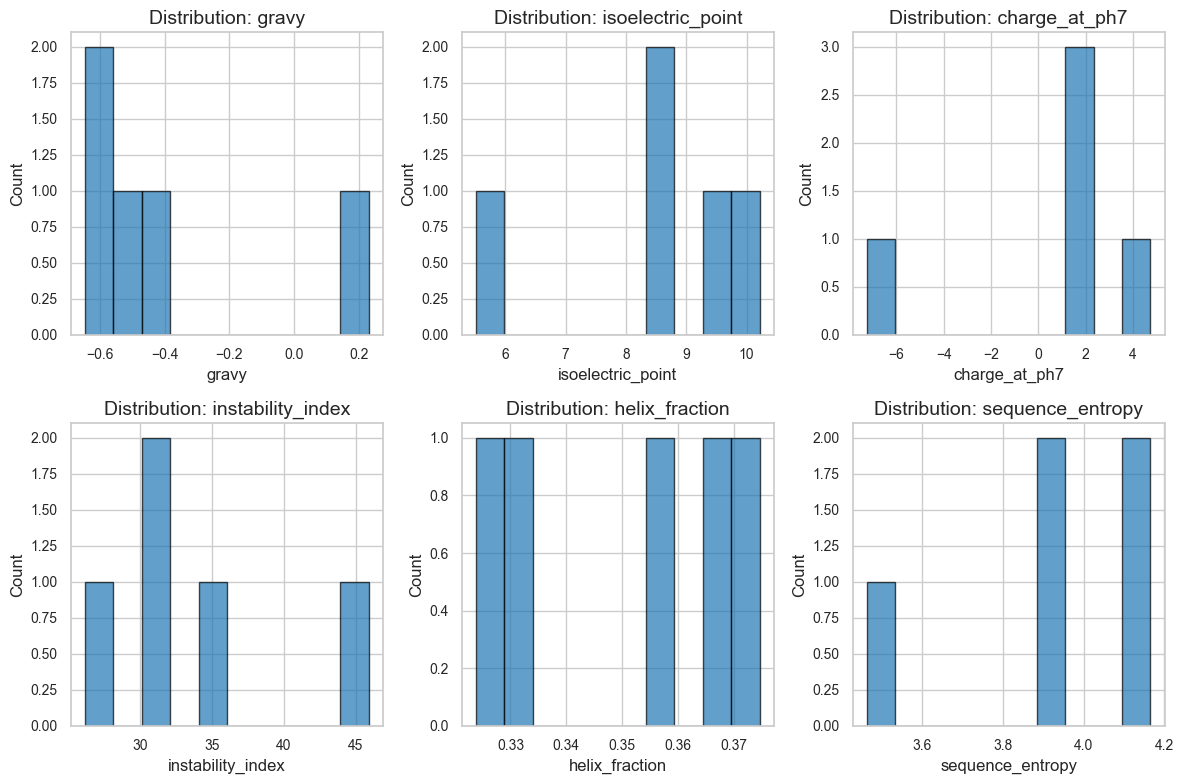

In [25]:
# Visualise feature distributions
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

features_to_plot = ['gravy', 'isoelectric_point', 'charge_at_ph7', 
                    'instability_index', 'helix_fraction', 'sequence_entropy']

for ax, feat in zip(axes, features_to_plot):
    values = [calculate_all_features(p.sequence)[feat] for p in library]
    ax.hist(values, bins=10, edgecolor='black', alpha=0.7)
    ax.set_xlabel(feat)
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution: {feat}')

plt.tight_layout()
save_figure(fig, FIGURES_DIR / "physchem_feature_distribution_barplots.png")
plt.show()

## 8. Summary and Next Steps

In this notebook, we covered the complete protein embedding workflow:

### What We Learned

1. **Protein representation**: Using `Protein` and `ProteinLibrary` classes
2. **ESM-2 embeddings**: High-dimensional learned representations (320-2560 dim)
3. **Physicochemical features**: Interpretable biochemical descriptors (~436 features)
4. **Embedding fusion**: Combining multiple embedding types
5. **Visualisation**: Exploring embedding spaces with PCA

### Key Outputs

- `library_with_embeddings.json`: Complete library with all embeddings
- `esm2_embeddings.npy`: ESM-2 embedding matrix
- `physicochemical_embeddings.npy`: Physicochemical feature matrix
- `fused_embeddings.npy`: Combined embedding matrix

### Next Steps

- **Notebook 02**: Process Cell Painting phenotype data
- **Notebook 03**: Train protein-to-phenotype prediction models
- **Notebook 04**: Use active learning for experiment selection

### Tips for Production Use

1. **Use larger ESM-2 models**: `esm2_t36_3B_UR50D` for best accuracy
2. **Enable caching**: Set `cache_dir` to avoid recomputing embeddings
3. **Batch processing**: Process proteins in batches for GPU efficiency
4. **Validate sequences**: Use `validate_sequence()` before embedding

In [26]:
# Final summary
print("=" * 60)
print("EMBEDDING SUMMARY")
print("=" * 60)
print(f"\nLibrary: {library.name}")
print(f"Proteins: {len(library)}")
print(f"\nEmbedding dimensions:")
for emb_type in ["esm2", "physicochemical", "fused"]:
    dim = library.get_embedding_matrix(emb_type).shape[1]
    print(f"  {emb_type}: {dim}")
print(f"\nOutput directory: {output_dir.absolute()}")
print("=" * 60)

EMBEDDING SUMMARY

Library: de_novo_designs_v1
Proteins: 5

Embedding dimensions:
  esm2: 320
  physicochemical: 436
  fused: 756

Output directory: c:\Users\adou0002\protophen\notebooks\outputs\01_protein_embeddings\embeddings
